### Plotting with synthetic data

In this notebook, I am documenting a step by step process in generating synthetic data and inversion. The main goal is to produce a proper manual for personal and future references for others who intend to continue this work.

Prior to this notebook, I have run the make file in the terminal to generate the files required for synthetic observations and inversion.

In [1]:
import numpy as np
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

### Generating synthetic points 
using script generatedualtemplatepoints.py which will generate two sets of points to represent snow and ice each.

The model of snow and ice thickness can be edited in snowicesynthetic.cpp. For this case, I've kept with simple Gaussian blobs.

In [2]:
# max and min
minlat = 0
maxlat = 360
minlon = 0
maxlon = 360

# number of observation poitns
observation_points = 600

In [3]:
subprocess.run([
        "python", "../../scripts/generatedualtemplatepoints.py",
        "-A", str(observation_points),  # create 600 observation points for 'A' 
        "-B", str(observation_points),  # create 600 observaton points for 'B'
        "-o", "synthetic/datatemplate.txt",  # creates output directory for the synthetic points
        "--xmin", str(minlon), "--xmax", str(maxlon),
        "--ymin", str(minlat), "--ymax", str(maxlat)
 ])

CompletedProcess(args=['python', '../../scripts/generatedualtemplatepoints.py', '-A', '600', '-B', '600', '-o', 'synthetic/datatemplate.txt', '--xmin', '0', '--xmax', '360', '--ymin', '0', '--ymax', '360'], returncode=0)

The data is now in the folder synthetic/datatemplate.txt

There will be five columns in the datatemplate.txt file 
The only columns that are important in this is the first three column:
Longitude Latitude Model

For Model: 0 is A and 1 is B

The last two columns are represented as Value and Sigma which are kept at 0 and 1 respectively as there are no actual values for each point. This is just generated here so that the actual values obtained later is easier to append.

### Generate synthetic observations

using ./mksynthetic to generate synthetic satellite observations. This will generate two situations. One with noise and one without.

The dataset with noise is analogous to actual satellite measurement and the one without is what we would expect in an ideal satellite measurement of full penetration.

In [4]:
A = "SyntheticSnow"
B = "SyntheticIce"

# Create the observations file
subprocess.run([
    "./mksynthetic", 
    "-m", str(A), # Model for snow
    "-m", str(B), # Model for ice
    "-i", "synthetic/datatemplate.txt",    # input the generated points
    "-x", str(minlon), "-X", str(maxlon),  # same region bounds as before
    "-y", str(minlat), "-Y", str(maxlat),
    "-o", "synthetic/synthetic_obs.txt",     # Observations with noise
    "-O", "synthetic/synthetic_true.txt",    # Observations without noise, the 'actual' data
    "-n", str(0.1),                           # Standard deviation of independent Gaussian noise to be added to both snow and ice
    "-I", "synthetic/syntheticobs_true.img",  # translated image of the actual data
    "-W", str(360), "-H", str(360)            # width and height of the image
])

Model  0 : SyntheticSnow
Model  1 : SyntheticIce
1200 observations


CompletedProcess(args=['./mksynthetic', '-m', 'SyntheticSnow', '-m', 'SyntheticIce', '-i', 'synthetic/datatemplate.txt', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-o', 'synthetic/synthetic_obs.txt', '-O', 'synthetic/synthetic_true.txt', '-n', '0.1', '-I', 'synthetic/syntheticobs_true.img', '-W', '360', '-H', '360'], returncode=0)

There should now be 4 files added to the synthetic folder.

obs.txt and true.txt file should have the same 5 columns mentioned before with now actual values to the Value and Sigma column. (sigma column should match with the Gaussian noise added). Note that the first row has the number of total observations, so this should be skipped during plotting.

The .img are converted files of the actual data to represent better in plotting. This can be done with matplotlib imshow

### Plotting the actual synthetic data

using img.A and img.B files

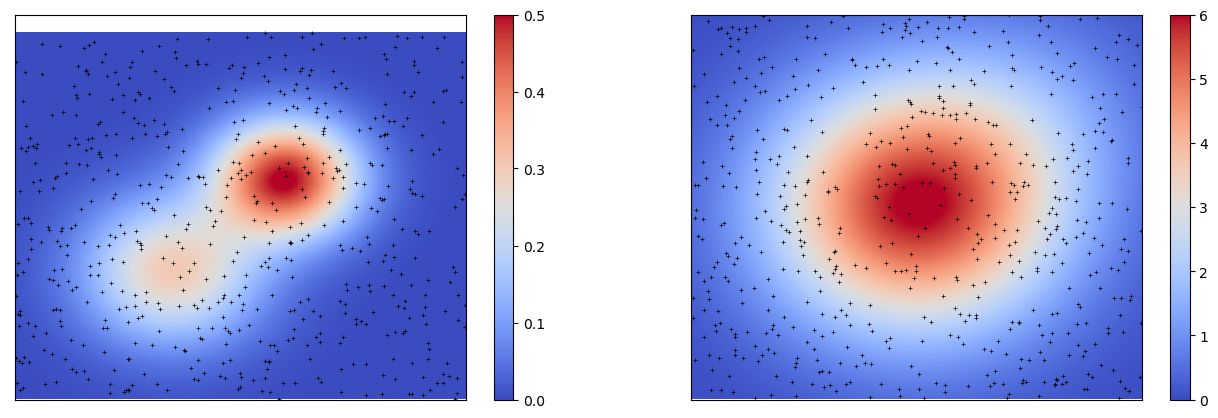

In [5]:
# Loading the data
imgA = np.loadtxt("synthetic/syntheticobs_true.img.A")
imgB = np.loadtxt("synthetic/syntheticobs_true.img.B")

true = pd.read_table("synthetic/datatemplate.txt", skiprows=1, names=['Lon','Lat','Type','Value','Sigma'], delimiter='\s+')

# Creating 2 plots next to each other
fig = plt.figure(figsize=(16, 5))

# First subplot
ax1 = fig.add_subplot(121)
ax1.set_xlim(0, 360)
img1 = ax1.imshow(imgA, cmap='coolwarm', aspect='auto', interpolation='None', origin='lower', vmin=0, vmax=0.5) 
# ax1.set_title('Synthetic Snow Depth (m)')
plt.colorbar(img1, ax=ax1)  # Use img1 for colorbar
true[true['Type'] == 0].plot(kind="scatter", x='Lon', y='Lat', ax=ax1, marker='+', color='k', s=10, linewidth=0.5)
ax1.set_xticks([])
ax1.set_yticks([])

# Second subplot
ax2 = fig.add_subplot(122)
ax2.set_xlim(0, 360)
img2 = ax2.imshow(imgB, cmap='coolwarm', aspect='auto', origin='lower',vmin=0, vmax=6) 
# ax2.set_title('Synthetic Ice Thickness (m)')
plt.colorbar(img2, ax=ax2)  # Use img2 for colorbar
true[true['Type'] == 1].plot(kind="scatter", x='Lon', y='Lat', ax=ax2, marker='+', color='k', s=10, linewidth=0.5)
ax2.set_xticks([])
ax2.set_yticks([])

# Hide axis labels for both subplots
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.show()

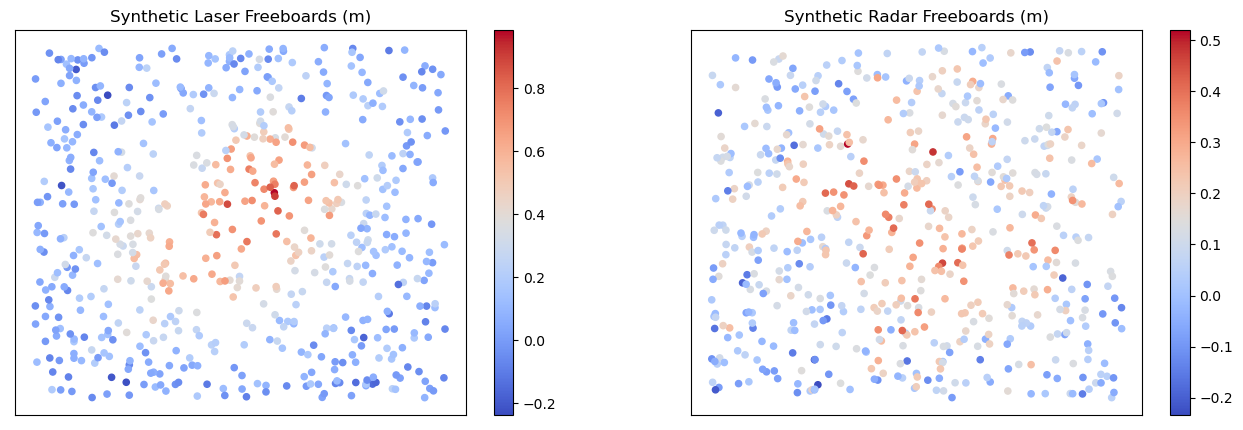

In [6]:
# Loading the data
obs = pd.read_table("synthetic/synthetic_obs.txt", skiprows=1, names=["Lon", "Lat", "Type", "Value", "Sigma"], delimiter="\s+")

# Creating 2 plots next to each other
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# First subplot
obs[obs['Type'] == 1].plot(kind="scatter", x='Lon', y='Lat', c="Value", ax=axes[0], cmap='coolwarm', colorbar=True)
axes[0].set_title('Synthetic Laser Freeboards (m)')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xticks([])
axes[0].set_yticks([])
cbar1 = axes[0].collections[0].colorbar
cbar1.set_label('')  # Set label to empty string

# Second subplot
obs[obs['Type'] == 0].plot(kind="scatter", x='Lon', y='Lat', c="Value", ax=axes[1], cmap='coolwarm', colorbar=True)
axes[1].set_title('Synthetic Radar Freeboards (m)')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xticks([])
axes[1].set_yticks([])
cbar2 = axes[1].collections[0].colorbar
cbar2.set_label('')  # Set label to empty string

plt.show()


### Inversion

Inversion using Delauney-Clougner parameter with 4 chains with 1 temperature for each chain.

In [7]:
parametrization = 1  # Tessalation parameter, 0 for Voronoi, 1 for Delauney, 2 for Delauney-Clougner
iterations_number = 250000
verbosity = 5000
independent_chains = 4
temperature_levels = 1
maximum_temperature = 5.0
iterations_between_tempering_attempts = 10

# Run inversion
subprocess.run([
    "mpirun", "-np", str(independent_chains * temperature_levels),
    "./snow_icept", 
    "-i", "synthetic/synthetic_obs.txt", 
    "-o", "results/", 
    "-P", "priors/synthetic/prior_snow.txt",
    "-P", "priors/synthetic/prior_ice.txt", 
    "-M", "priors/synthetic/positionprior_snow.txt", 
    "-M", "priors/synthetic/positionprior_ice.txt",
    "-H", "priors/synthetic/hierarchical_snow.txt", 
    "-H", "priors/synthetic/hierarchical_ice.txt", 
    "-x", str(minlon), "-X", str(maxlon),
    "-y", str(minlat), "-Y", str(maxlat),
    "-A", str(parametrization), "-A", str(parametrization),
    "-t", str(iterations_number), 
    "-v", str(verbosity),
    "-c", str(independent_chains),   # Independent chains to run at each temperature
    "-K", str(temperature_levels),   # Number of temperature levels for parallel tempering
    "-m", str(maximum_temperature),  # Maximum temperature for the parallel tempering log temperature
    "-e", str(iterations_between_tempering_attempts)    # Number of iterations between parallel tempering exchange attempts
    ])

CompletedProcess(args=['mpirun', '-np', '4', './snow_icept', '-i', 'synthetic/synthetic_obs.txt', '-o', 'results/', '-P', 'priors/synthetic/prior_snow.txt', '-P', 'priors/synthetic/prior_ice.txt', '-M', 'priors/synthetic/positionprior_snow.txt', '-M', 'priors/synthetic/positionprior_ice.txt', '-H', 'priors/synthetic/hierarchical_snow.txt', '-H', 'priors/synthetic/hierarchical_ice.txt', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-A', '1', '-A', '1', '-t', '250000', '-v', '5000', '-c', '4', '-K', '1', '-m', '5.0', '-e', '10'], returncode=0)

In [8]:
# Step 3: Compute means 
parameter_W = 360
parameter_H = 360
skipping = 50000
thinning = 5

file_snow = f"images/snow"
file_ice = f"images/ice"


subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "results/ch.dat", "-o", file_snow,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_snow + "_stddev"),
            "-m", str(file_snow + "_median"),
            "-I", str(0)])

CompletedProcess(args=['mpirun', '-np', '4', './post_mean_mpi', '-i', 'results/ch.dat', '-o', 'images/snow', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-s', '50000', '-t', '5', '-A', '1', '-A', '1', '-W', '360', '-H', '360', '-D', 'images/snow_stddev', '-m', 'images/snow_median', '-I', '0'], returncode=0)

In [9]:
subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "results/ch.dat", "-o", file_ice,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_ice + "_stddev"),
            "-m", str(file_ice + "_median"),
            "-I", str(1)])

CompletedProcess(args=['mpirun', '-np', '4', './post_mean_mpi', '-i', 'results/ch.dat', '-o', 'images/ice', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-s', '50000', '-t', '5', '-A', '1', '-A', '1', '-W', '360', '-H', '360', '-D', 'images/ice_stddev', '-m', 'images/ice_median', '-I', '1'], returncode=0)

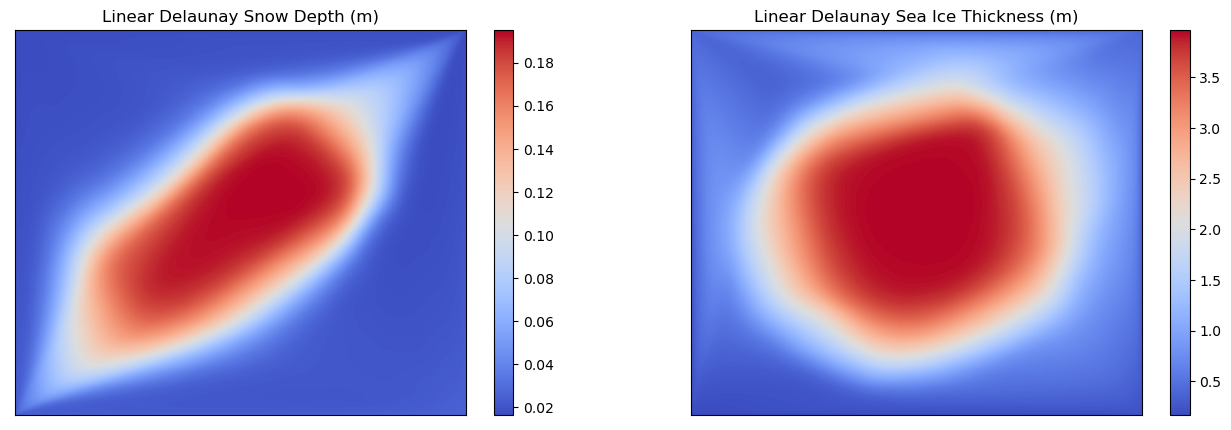

In [10]:
file_snow = f"images/snow"
file_ice = f"images/ice"
ice = np.loadtxt(file_ice)
snow = np.loadtxt(file_snow)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

img = ax[0].imshow(snow,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Linear Delaunay Snow Depth (m)')
ax[0].set_xticks([])
ax[0].set_yticks([])

img = ax[1].imshow(ice,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Linear Delaunay Sea Ice Thickness (m)')
ax[1].set_xticks([])
ax[1].set_yticks([])


plt.show()

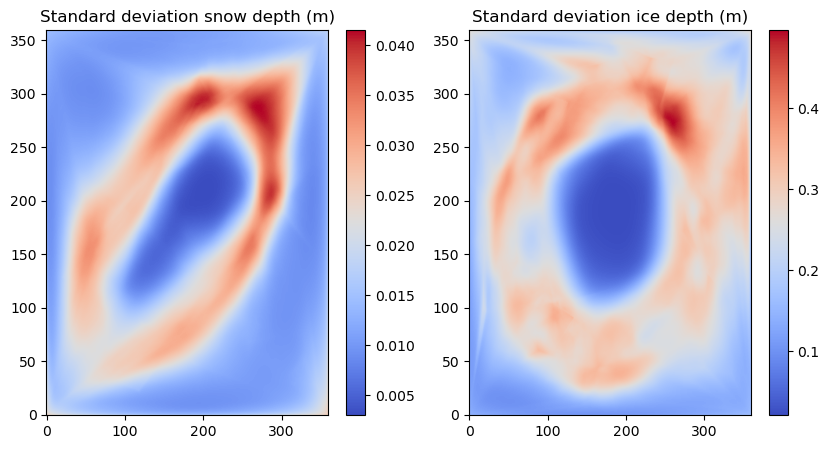

In [11]:
std_snow = f"images/snow_stddev"
std_ice = f"images/ice_stddev"
snow_median = np.loadtxt(std_snow)
ice_median = np.loadtxt(std_ice)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img = ax[0].imshow(snow_median,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Standard deviation snow depth (m)')

img = ax[1].imshow(ice_median,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Standard deviation ice depth (m)')

plt.show()


### Inversion for Voronoi

In [12]:
parametrization = 0  # Tessalation parameter, 0 for Voronoi, 1 for Delauney, 2 for Delauney-Clougner

# keeping all other parameters the same
iterations_number = 250000
verbosity = 5000
independent_chains = 4
temperature_levels = 1
maximum_temperature = 5.0
iterations_between_tempering_attempts = 10

# Run inversion
subprocess.run([
    "mpirun", "-np", str(independent_chains * temperature_levels),
    "./snow_icept", 
    "-i", "synthetic/synthetic_obs.txt", 
    "-o", "resultsvoronoi/", 
    "-P", "priors/synthetic/prior_snow.txt",
    "-P", "priors/synthetic/prior_ice.txt", 
    "-M", "priors/synthetic/positionprior_snow.txt", 
    "-M", "priors/synthetic/positionprior_ice.txt",
    "-H", "priors/synthetic/hierarchical_snow.txt", 
    "-H", "priors/synthetic/hierarchical_ice.txt", 
    "-x", str(minlon), "-X", str(maxlon),
    "-y", str(minlat), "-Y", str(maxlat),
    "-A", str(parametrization), "-A", str(parametrization),
    "-t", str(iterations_number), 
    "-v", str(verbosity),
    "-c", str(independent_chains),   # Independent chains to run at each temperature
    "-K", str(temperature_levels),   # Number of temperature levels for parallel tempering
    "-m", str(maximum_temperature),  # Maximum temperature for the parallel tempering log temperature
    "-e", str(iterations_between_tempering_attempts)    # Number of iterations between parallel tempering exchange attempts
    ])

CompletedProcess(args=['mpirun', '-np', '4', './snow_icept', '-i', 'synthetic/synthetic_obs.txt', '-o', 'resultsvoronoi/', '-P', 'priors/synthetic/prior_snow.txt', '-P', 'priors/synthetic/prior_ice.txt', '-M', 'priors/synthetic/positionprior_snow.txt', '-M', 'priors/synthetic/positionprior_ice.txt', '-H', 'priors/synthetic/hierarchical_snow.txt', '-H', 'priors/synthetic/hierarchical_ice.txt', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-A', '0', '-A', '0', '-t', '250000', '-v', '5000', '-c', '4', '-K', '1', '-m', '5.0', '-e', '10'], returncode=0)

In [13]:
# Step 3: Compute means 

file_snow = f"imagesvoronoi/snow"
file_ice = f"imagesvoronoi/ice"

subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "resultsvoronoi/ch.dat", "-o", file_snow,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_snow + "_stddev"),
            "-m", str(file_snow + "_median"),
            "-I", str(0)])

subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "resultsvoronoi/ch.dat", "-o", file_ice,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_ice + "_stddev"),
            "-m", str(file_ice + "_median"),
            "-I", str(1)])

CompletedProcess(args=['mpirun', '-np', '4', './post_mean_mpi', '-i', 'resultsvoronoi/ch.dat', '-o', 'imagesvoronoi/ice', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-s', '50000', '-t', '5', '-A', '0', '-A', '0', '-W', '360', '-H', '360', '-D', 'imagesvoronoi/ice_stddev', '-m', 'imagesvoronoi/ice_median', '-I', '1'], returncode=0)

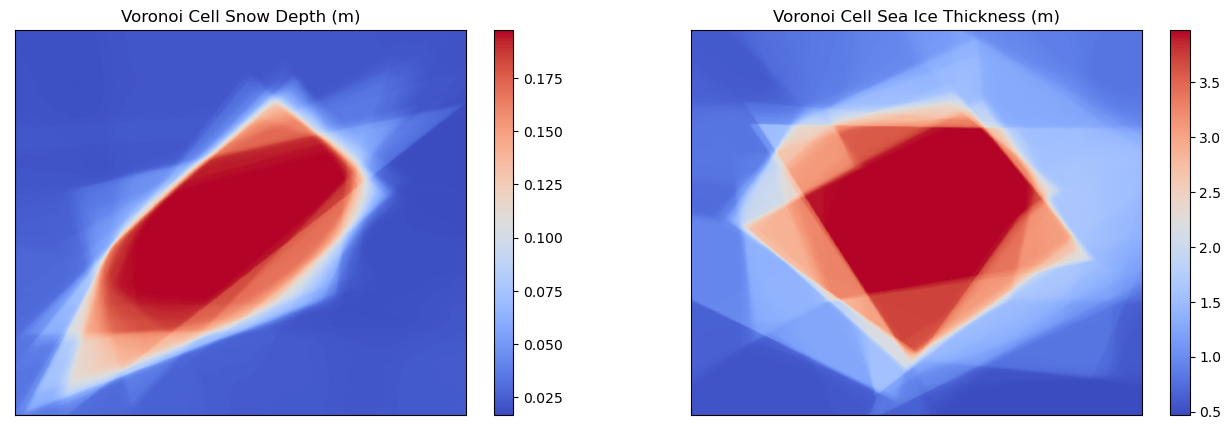

In [14]:
file_snow = f"imagesvoronoi/snow"
file_ice = f"imagesvoronoi/ice"
ice = np.loadtxt(file_ice)
snow = np.loadtxt(file_snow)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

img = ax[0].imshow(snow,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Voronoi Cell Snow Depth (m)')
ax[0].set_xticks([])
ax[0].set_yticks([])

img = ax[1].imshow(ice,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Voronoi Cell Sea Ice Thickness (m)')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

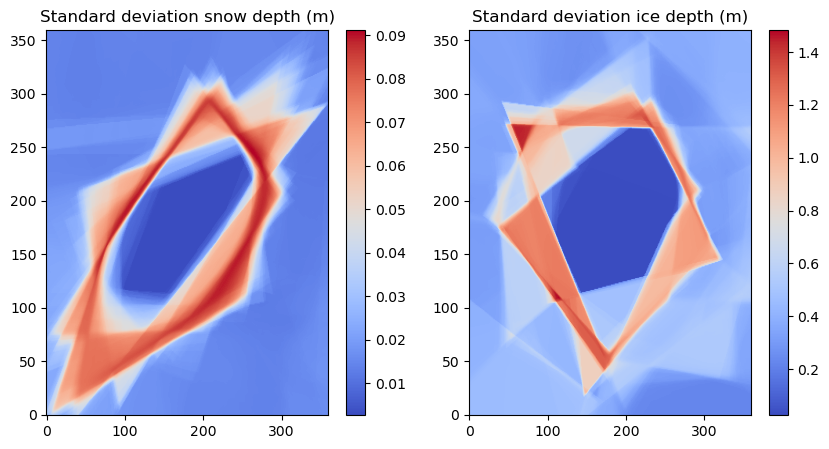

In [15]:
std_snow = f"imagesvoronoi/snow_stddev"
std_ice = f"imagesvoronoi/ice_stddev"
snow_median = np.loadtxt(std_snow)
ice_median = np.loadtxt(std_ice)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img = ax[0].imshow(snow_median,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Standard deviation snow depth (m)')

img = ax[1].imshow(ice_median,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Standard deviation ice depth (m)')

plt.show()


### Inversion using Delaunay parametrization with Clough-Tocher interpolation

In [16]:
parametrization = 2  # Tessalation parameter, 0 for Voronoi, 1 for Delauney, 2 for Delauney-Clougner

# keeping all other parameters the same
iterations_number = 250000
verbosity = 5000
independent_chains = 4
temperature_levels = 1
maximum_temperature = 5.0
iterations_between_tempering_attempts = 10

# Run inversion
subprocess.run([
    "mpirun", "-np", str(independent_chains * temperature_levels),
    "./snow_icept", 
    "-i", "synthetic/synthetic_obs.txt", 
    "-o", "resultsclough/", 
    "-P", "priors/synthetic/prior_snow.txt",
    "-P", "priors/synthetic/prior_ice.txt", 
    "-M", "priors/synthetic/positionprior_snow.txt", 
    "-M", "priors/synthetic/positionprior_ice.txt",
    "-H", "priors/synthetic/hierarchical_snow.txt", 
    "-H", "priors/synthetic/hierarchical_ice.txt", 
    "-x", str(minlon), "-X", str(maxlon),
    "-y", str(minlat), "-Y", str(maxlat),
    "-A", str(parametrization), "-A", str(parametrization),
    "-t", str(iterations_number), 
    "-v", str(verbosity),
    "-c", str(independent_chains),   # Independent chains to run at each temperature
    "-K", str(temperature_levels),   # Number of temperature levels for parallel tempering
    "-m", str(maximum_temperature),  # Maximum temperature for the parallel tempering log temperature
    "-e", str(iterations_between_tempering_attempts)    # Number of iterations between parallel tempering exchange attempts
])

CompletedProcess(args=['mpirun', '-np', '4', './snow_icept', '-i', 'synthetic/synthetic_obs.txt', '-o', 'resultsclough/', '-P', 'priors/synthetic/prior_snow.txt', '-P', 'priors/synthetic/prior_ice.txt', '-M', 'priors/synthetic/positionprior_snow.txt', '-M', 'priors/synthetic/positionprior_ice.txt', '-H', 'priors/synthetic/hierarchical_snow.txt', '-H', 'priors/synthetic/hierarchical_ice.txt', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-A', '2', '-A', '2', '-t', '250000', '-v', '5000', '-c', '4', '-K', '1', '-m', '5.0', '-e', '10'], returncode=0)

In [17]:
# Step 3: Compute means 
parameter_W = 360
parameter_H = 360
skipping = 50000
thinning = 5

file_snow = f"imagesclougner/snow"
file_ice = f"imagesclougner/ice"

subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "resultsclough/ch.dat", "-o", file_snow,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_snow + "_stddev"),
            "-m", str(file_snow + "_median"),
            "-I", str(0)])

subprocess.run([
            "mpirun", "-np", str(independent_chains),
            "./post_mean_mpi", "-i", 
            "resultsclough/ch.dat", "-o", file_ice,
            "-x", str(minlon), "-X", str(maxlon),
            "-y", str(minlat), "-Y", str(maxlat),
            "-s", str(skipping),
            "-t", str(thinning),
            "-A", str(parametrization), "-A", str(parametrization),
            "-W", str(parameter_W), "-H", str(parameter_H),
            "-D", str(file_ice + "_stddev"),
            "-m", str(file_ice + "_median"),
            "-I", str(1)])

CompletedProcess(args=['mpirun', '-np', '4', './post_mean_mpi', '-i', 'resultsclough/ch.dat', '-o', 'imagesclougner/ice', '-x', '0', '-X', '360', '-y', '0', '-Y', '360', '-s', '50000', '-t', '5', '-A', '2', '-A', '2', '-W', '360', '-H', '360', '-D', 'imagesclougner/ice_stddev', '-m', 'imagesclougner/ice_median', '-I', '1'], returncode=0)

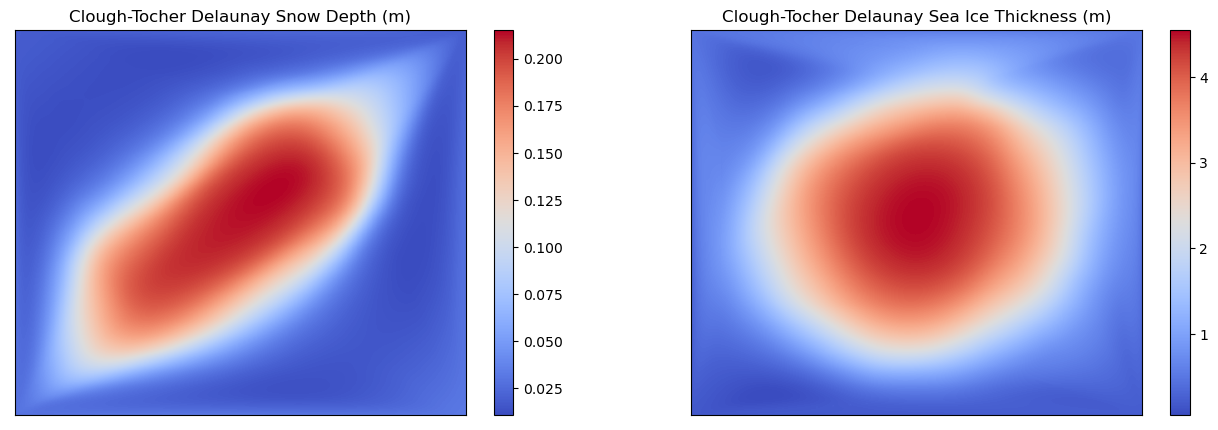

In [18]:
file_snow = f"imagesclougner/snow"
file_ice = f"imagesclougner/ice"
ice = np.loadtxt(file_ice)
snow = np.loadtxt(file_snow)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

img = ax[0].imshow(snow,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Clough-Tocher Delaunay Snow Depth (m)')
ax[0].set_xticks([])
ax[0].set_yticks([])

img = ax[1].imshow(ice,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Clough-Tocher Delaunay Sea Ice Thickness (m)')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

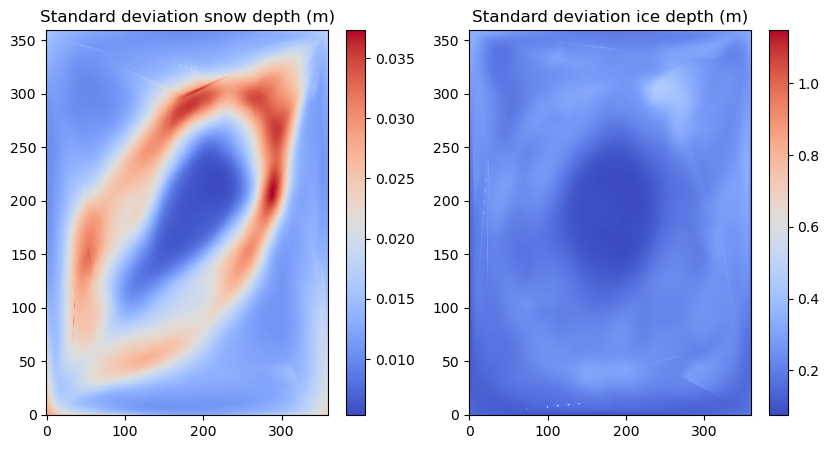

In [19]:
std_snow = f"imagesclougner/snow_stddev"
std_ice = f"imagesclougner/ice_stddev"
snow_median = np.loadtxt(std_snow)
ice_median = np.loadtxt(std_ice)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img = ax[0].imshow(snow_median,origin='lower', cmap = 'coolwarm',aspect= 'auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Standard deviation snow depth (m)')

img = ax[1].imshow(ice_median,origin='lower', cmap= 'coolwarm', aspect= 'auto')
plt.colorbar(img, ax=ax[1])
ax[1].set_title('Standard deviation ice depth (m)')

plt.show()


### Analysis

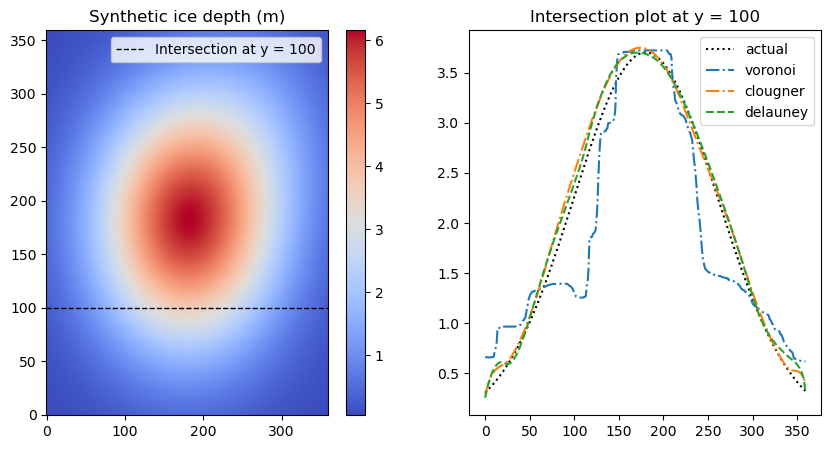

In [20]:
# Loading the data
synthetic = np.loadtxt("synthetic/syntheticobs_true.img.B")
voronoi = np.loadtxt("imagesvoronoi/ice")
clougner = np.loadtxt("imagesclougner/ice")
delauyney = np.loadtxt("images/ice")

fig,ax = plt.subplots(1,2, figsize= (10, 5))

# Plot the original snow freeboard plot
img = ax[0].imshow(synthetic, cmap='coolwarm', aspect='auto', interpolation='None', origin='lower') 
ax[0].set_title('Synthetic ice depth (m)')
plt.colorbar(img, ax=ax[0])

# Plot the intersection line at y = 100
y_intersection = 100
ax[0].axhline(y_intersection, color='black', linestyle='--', linewidth=1, label=f'Intersection at y = {y_intersection}')
ax[0].legend()

intersection_synthetic = synthetic[y_intersection, :]
intersection_voronoi = voronoi[y_intersection, :]
intersection_clougner = clougner[y_intersection, :]
intersection_delauney = delauyney[y_intersection, :]

ax[1].set_title('Intersection plot at y = 100')

ax[1].plot(intersection_synthetic, 'k:', label = "actual")
ax[1].plot(intersection_voronoi, '-.', label = "voronoi")
ax[1].plot(intersection_clougner,'-.', label ="clougner")
ax[1].plot(intersection_delauney,'--', label = 'delauney')

ax[1].legend()

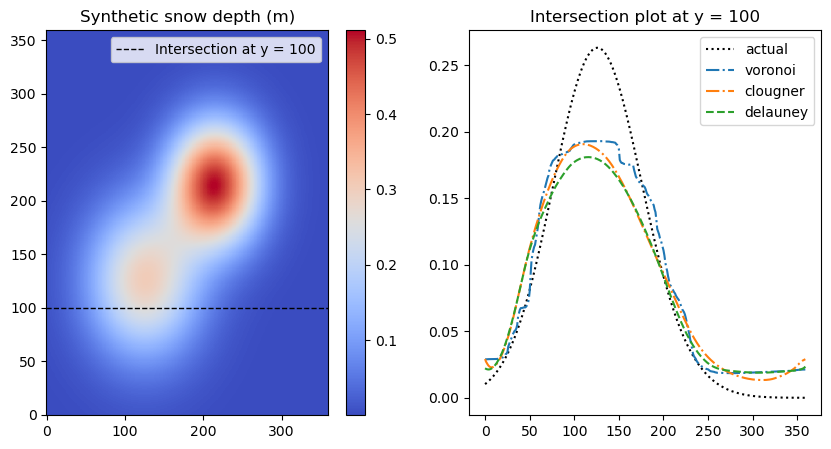

In [21]:
# Loading the data
synthetic = np.loadtxt("synthetic/syntheticobs_true.img.A")
voronoi = np.loadtxt("imagesvoronoi/snow")
clougner = np.loadtxt("imagesclougner/snow")
delauyney = np.loadtxt("images/snow")

fig,ax = plt.subplots(1,2, figsize= (10, 5))

# Plot the original snow freeboard plot
img = ax[0].imshow(synthetic, cmap='coolwarm', aspect='auto', interpolation='None', origin='lower') 
ax[0].set_title('Synthetic snow depth (m)')
plt.colorbar(img, ax=ax[0])

# Plot the intersection line at y = 100
y_intersection = 100
ax[0].axhline(y_intersection, color='black', linestyle='--', linewidth=1, label=f'Intersection at y = {y_intersection}')
ax[0].legend()

intersection_synthetic = synthetic[y_intersection, :]
intersection_voronoi = voronoi[y_intersection, :]
intersection_clougner = clougner[y_intersection, :]
intersection_delauney = delauyney[y_intersection, :]

ax[1].set_title('Intersection plot at y = 100')

ax[1].plot(intersection_synthetic, 'k:', label = "actual")
ax[1].plot(intersection_voronoi, '-.', label = "voronoi")
ax[1].plot(intersection_clougner,'-.', label ="clougner")
ax[1].plot(intersection_delauney,'--', label = 'delauney')

ax[1].legend()